In [1]:
import tensorflow as tf
import numpy as np
import mnist_data
import os
# import beta_vae as vae
import vae
import plot_utils
import glob
import random
import matplotlib.pyplot as plt
import cv2

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
IMAGE_SIZE_MNIST = 28
dim_z=20
n_hidden=500
learn_rate=1e-3
n_epochs=20
batch_size=128
path=os.path.join(os.getcwd(),'result')
if not os.path.exists(path):
    os.system('mkdir '+path)
RESULTS_DIR=path
ADD_NOISE=False
dim_img = IMAGE_SIZE_MNIST**2
beta=2.0

PRR=True
PRR_n_img_x=10
PRR_n_img_y=10
PRR_resize_factor=1.0
PMLR=False
PMLR_n_img_x=20
PMLR_n_img_y=20
PMLR_resize_factor=1.0
PMLR_z_range=2.0
PMLR_n_samples=5000

准备new domain数据

In [3]:
newdata_path=os.path.join(os.getcwd(),'mnist/pr')
propotion=0.7
random.seed(100)
imlist=os.listdir(newdata_path)
train_font_size=int(len(imlist)*0.7)
random.shuffle(imlist)
trainlist=imlist[:train_font_size]
testlist=imlist[train_font_size:]
test_font_size=len(testlist)
one_hot=np.eye(10)
train_font_data=np.zeros([train_font_size,794])
test_font_data=np.zeros([test_font_size,784])
test_font_labels=np.zeros([test_font_size,10])
c=0
for im in trainlist:
    label=int(im.split('_')[0])
#     print(label)
    img=cv2.imread(newdata_path+'/'+im,0).reshape(784)/255.0
#     print(img.shape)
    train_font_data[c]=np.concatenate([img,one_hot[label]])
    
    c+=1
    
c=0
for im in testlist:
    label=int(im.split('_')[0])
    img=cv2.imread(newdata_path+'/'+im,0).reshape(784)/255.0
    test_font_data[c]=img
    test_font_labels[c]=one_hot[label]
    c+=1


array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])

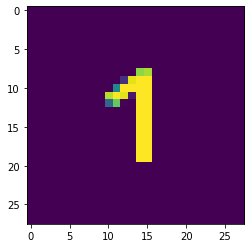

In [4]:
plt.imshow(train_font_data[1,:-10].reshape([28,28]))
train_font_data[1,-10:]

准备original domain 数据

In [9]:
# train_total_data, train_size, _, _, test_data, test_labels = mnist_data.prepare_MNIST_data()

Extracting data/train-images-idx3-ubyte.gz
Extracting data/train-labels-idx1-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz


train_total_data采用one-hot编码

array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])

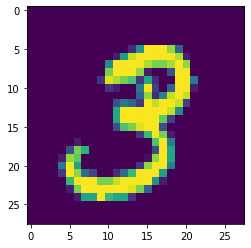

In [8]:
# plt.imshow(train_total_data[1,:-10].reshape([28,28]))
# train_total_data[1,-10:]

In [5]:

""" build graph """
# input placeholders
# In denoising-autoencoder, x_hat == x + noise, otherwise x_hat == x
x_hat = tf.placeholder(tf.float32, shape=[None, dim_img], name='input_img')
x = tf.placeholder(tf.float32, shape=[None, dim_img], name='target_img')

# dropout
keep_prob = tf.placeholder(tf.float32, name='keep_prob')

# input for PMLR
z_in = tf.placeholder(tf.float32, shape=[None, dim_z], name='latent_variable')

#vae
y, z, loss, neg_marginal_likelihood, KL_divergence = vae.autoencoder(x_hat, x, dim_img, dim_z, n_hidden, keep_prob)

# beta vae
# y, z, loss, neg_marginal_likelihood, KL_divergence = vae.autoencoder(x_hat, x, dim_img, dim_z, n_hidden, keep_prob,beta)

# optimization
train_op = tf.train.AdamOptimizer(learn_rate).minimize(loss)

W0914 11:22:12.142266 139752263956288 deprecation_wrapper.py:119] From /home/yuemei.zhu/tensorflow-mnist-VAE/vae.py:5: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.

W0914 11:22:12.980520 139752263956288 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W0914 11:22:12.982122 139752263956288 deprecation_wrapper.py:119] From /home/yuemei.zhu/tensorflow-mnist-VAE/vae.py:11: The name tf.get_variable is deprecated. Please use tf.compat.v1.get_variable instead.

W0914 11:22:12.997444 139752263956288 deprecation.py:506] From /home/yuemei.zhu/tensorflow-mnist-VAE/vae.py:15: calling dropout (from tensorflow.python.ops.nn_op

In [6]:
test_data=test_font_data
test_labels=test_font_labels
train_size=train_font_size

In [7]:
n_samples=train_size
""" training """

# Plot for reproduce performance
if PRR:
    PRR = plot_utils.Plot_Reproduce_Performance(RESULTS_DIR, PRR_n_img_x, PRR_n_img_y, IMAGE_SIZE_MNIST, IMAGE_SIZE_MNIST, PRR_resize_factor)

    x_PRR = test_data[0:PRR.n_tot_imgs, :]

    x_PRR_img = x_PRR.reshape(PRR.n_tot_imgs, IMAGE_SIZE_MNIST, IMAGE_SIZE_MNIST)
    PRR.save_images(x_PRR_img, name='input.jpg')

    if ADD_NOISE:
        x_PRR = x_PRR * np.random.randint(2, size=x_PRR.shape)
        x_PRR += np.random.randint(2, size=x_PRR.shape)

        x_PRR_img = x_PRR.reshape(PRR.n_tot_imgs, IMAGE_SIZE_MNIST, IMAGE_SIZE_MNIST)
        PRR.save_images(x_PRR_img, name='input_noise.jpg')

# Plot for manifold learning result
if PMLR and dim_z == 2:

    PMLR = plot_utils.Plot_Manifold_Learning_Result(RESULTS_DIR, PMLR_n_img_x, PMLR_n_img_y, IMAGE_SIZE_MNIST, IMAGE_SIZE_MNIST, PMLR_resize_factor, PMLR_z_range)

    x_PMLR = test_data[0:PMLR_n_samples, :]
    id_PMLR = test_labels[0:PMLR_n_samples, :]

    if ADD_NOISE:
        x_PMLR = x_PMLR * np.random.randint(2, size=x_PMLR.shape)
        x_PMLR += np.random.randint(2, size=x_PMLR.shape)

    decoded = vae.decoder(z_in, dim_img, n_hidden)
total_batch = int(n_samples / batch_size)
min_tot_loss = 1e99

with tf.Session() as sess:

    sess.run(tf.global_variables_initializer(), feed_dict={keep_prob : 0.9})

    for epoch in range(n_epochs):

        # Random shuffling
#         np.random.shuffle(train_total_data)
#         train_data_ = train_total_data[:, :-mnist_data.NUM_LABELS]
        np.random.shuffle(train_font_data)
        train_data_ = train_font_data[:, :-mnist_data.NUM_LABELS]


        # Loop over all batches
        for i in range(total_batch):
            # Compute the offset of the current minibatch in the data.
            offset = (i * batch_size) % (n_samples)
            batch_xs_input = train_data_[offset:(offset + batch_size), :]

            batch_xs_target = batch_xs_input

            # add salt & pepper noise
            if ADD_NOISE:
                batch_xs_input = batch_xs_input * np.random.randint(2, size=batch_xs_input.shape)
                batch_xs_input += np.random.randint(2, size=batch_xs_input.shape)

            _, tot_loss, loss_likelihood, loss_divergence = sess.run(
                (train_op, loss, neg_marginal_likelihood, KL_divergence),
                feed_dict={x_hat: batch_xs_input, x: batch_xs_target, keep_prob : 0.9})

        # print cost every epoch
        print("epoch %d: L_tot %03.2f L_likelihood %03.2f L_divergence %03.2f" % (epoch, tot_loss, loss_likelihood, loss_divergence))

        # if minimum loss is updated or final epoch, plot results
        if min_tot_loss > tot_loss or epoch+1 == n_epochs:
            min_tot_loss = tot_loss
            # Plot for reproduce performance
            if PRR:
                y_PRR = sess.run(y, feed_dict={x_hat: x_PRR, keep_prob : 1})
                y_PRR_img = y_PRR.reshape(PRR.n_tot_imgs, IMAGE_SIZE_MNIST, IMAGE_SIZE_MNIST)
                PRR.save_images(y_PRR_img, name="/PRR_epoch_%02d" %(epoch) + ".jpg")

            # Plot for manifold learning result
            if PMLR and dim_z == 2:
                y_PMLR = sess.run(decoded, feed_dict={z_in: PMLR.z, keep_prob : 1})
                y_PMLR_img = y_PMLR.reshape(PMLR.n_tot_imgs, IMAGE_SIZE_MNIST, IMAGE_SIZE_MNIST)
                PMLR.save_images(y_PMLR_img, name="/PMLR_epoch_%02d" % (epoch) + ".jpg")

                # plot distribution of labeled images
                z_PMLR = sess.run(z, feed_dict={x_hat: x_PMLR, keep_prob : 1})
                PMLR.save_scattered_image(z_PMLR,id_PMLR, name="/PMLR_map_epoch_%02d" % (epoch) + ".jpg")


epoch 0: L_tot 96.53 L_likelihood 85.98 L_divergence 10.54
epoch 1: L_tot 78.96 L_likelihood 67.85 L_divergence 11.12
epoch 2: L_tot 71.10 L_likelihood 58.55 L_divergence 12.55
epoch 3: L_tot 70.23 L_likelihood 56.45 L_divergence 13.78
epoch 4: L_tot 64.60 L_likelihood 51.23 L_divergence 13.37
epoch 5: L_tot 62.75 L_likelihood 49.09 L_divergence 13.67
epoch 6: L_tot 64.09 L_likelihood 49.34 L_divergence 14.74
epoch 7: L_tot 62.80 L_likelihood 47.81 L_divergence 14.99
epoch 8: L_tot 58.25 L_likelihood 44.27 L_divergence 13.98
epoch 9: L_tot 62.01 L_likelihood 47.06 L_divergence 14.95
epoch 10: L_tot 59.85 L_likelihood 45.62 L_divergence 14.23
epoch 11: L_tot 55.89 L_likelihood 41.75 L_divergence 14.14
epoch 12: L_tot 59.28 L_likelihood 43.57 L_divergence 15.71
epoch 13: L_tot 56.67 L_likelihood 40.44 L_divergence 16.23
epoch 14: L_tot 55.52 L_likelihood 40.92 L_divergence 14.60
epoch 15: L_tot 55.70 L_likelihood 41.19 L_divergence 14.51
epoch 16: L_tot 56.52 L_likelihood 41.65 L_diverge